# **VCD Implementation**

In [22]:
import torch
import torch.nn.functional as F

# Replace your gaussian_corrupt function with:
def gaussian_corrupt(pixel_values, noise_step=500):
    """Official VCD DDPM noise."""
    num_steps = 1000
    betas = torch.linspace(-6, 6, num_steps)
    betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, dim=0)
    alphas_bar_sqrt = torch.sqrt(alphas_prod)
    one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

    noise = torch.randn_like(pixel_values)
    alphas_t = alphas_bar_sqrt[noise_step]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[noise_step]

    return alphas_t * pixel_values + alphas_1_m_t * noise

def apply_vcd(logits_clean, logits_corr, alpha=1.0, beta=0.01, min_keep=50):
    logits_vcd = (1.0 + alpha) * logits_clean - alpha * logits_corr

    probs_clean = F.softmax(logits_clean, dim=-1)
    max_p = probs_clean.max(dim=-1, keepdim=True).values
    keep = probs_clean >= (beta * max_p)

    # ALWAYS keep at least top-k tokens
    topk_idx = torch.topk(probs_clean, k=min_keep, dim=-1).indices
    topk_mask = torch.zeros_like(keep).scatter_(1, topk_idx, True)
    keep = keep | topk_mask

    logits_vcd = logits_vcd.masked_fill(~keep, float("-inf"))
    return logits_vcd

def sample_next_token(logits, do_sample=True, temperature=1.0, top_p=0.9):
    """
    logits: (B, V)
    returns: (B,)
    """
    if not do_sample:
        return torch.argmax(logits, dim=-1)

    logits = logits / max(temperature, 1e-6)
    probs = F.softmax(logits, dim=-1)

    sorted_probs, sorted_idx = torch.sort(probs, descending=True, dim=-1)
    cdf = torch.cumsum(sorted_probs, dim=-1)

    cutoff = cdf > top_p
    cutoff[..., 0] = False  # always keep best token
    sorted_probs = sorted_probs.masked_fill(cutoff, 0.0)
    sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

    next_in_sorted = torch.multinomial(sorted_probs, 1).squeeze(-1)
    next_token = sorted_idx.gather(-1, next_in_sorted.unsqueeze(-1)).squeeze(-1)
    return next_token

In [19]:
from types import SimpleNamespace
import torch

@torch.no_grad()
def vcd_generate_hf_llava(
    model,
    processor,
    question,
    image,
    max_new_tokens=200,
    alpha=1.0,
    beta=0.1,
    noise_step=500,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    return_dict_in_generate=True,
    output_scores=True,
):
    model.eval()
    lm_device = model.get_input_embeddings().weight.device

    text = build_llava_prompt(processor, question)
    inputs = processor(images=image, text=text, return_tensors="pt", padding=True)

    input_ids = inputs["input_ids"].to(lm_device)
    attention_mask = inputs.get("attention_mask", torch.ones_like(input_ids)).to(lm_device)

    if "pixel_values" not in inputs:
        raise ValueError("processor output has no 'pixel_values'. Check your processor/model.")

    pixel_values = inputs["pixel_values"]
    try:
        pixel_values = pixel_values.to(lm_device)
    except Exception:
        pass

    pixel_corr = gaussian_corrupt(pixel_values,  noise_step=noise_step)
    eos_id = processor.tokenizer.eos_token_id

    # first forward (clean + corrupted)
    out_clean = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values=pixel_values,
        use_cache=True,
    )
    out_corr = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values=pixel_corr,
        use_cache=True,
    )

    past_clean = out_clean.past_key_values
    past_corr  = out_corr.past_key_values

    logits_clean = out_clean.logits[:, -1, :]  # (B, V)
    logits_corr  = out_corr.logits[:, -1, :]   # (B, V)

    generated_tokens = []
    scores = []  # list of (B, V) logits for each generated step (VCD logits)

    for _ in range(max_new_tokens):
        logits_vcd = apply_vcd(logits_clean, logits_corr, alpha=alpha, beta=beta)  # (B, V)

        if output_scores:
            scores.append(logits_vcd)

        next_token = sample_next_token(
            logits_vcd, do_sample=do_sample, temperature=temperature, top_p=top_p
        )  # (B,)

        generated_tokens.append(next_token)

        if eos_id is not None and (next_token == eos_id).all():
            break

        step_ids = next_token.unsqueeze(-1)  # (B,1)

        # extend attention mask for decoder-only generation
        attention_mask = torch.cat(
            [attention_mask,
             torch.ones((attention_mask.size(0), 1), device=lm_device, dtype=attention_mask.dtype)],
            dim=1
        )

        # next step: reuse cache; image already encoded on first step for most LLaVA-like impls
        out_clean = model(
            input_ids=step_ids,
            attention_mask=attention_mask,
            pixel_values=None,
            past_key_values=past_clean,
            use_cache=True,
        )
        out_corr = model(
            input_ids=step_ids,
            attention_mask=attention_mask,
            pixel_values=None,
            past_key_values=past_corr,
            use_cache=True,
        )

        past_clean = out_clean.past_key_values
        past_corr  = out_corr.past_key_values
        logits_clean = out_clean.logits[:, -1, :]
        logits_corr  = out_corr.logits[:, -1, :]

    if len(generated_tokens) == 0:
        # mimic HF generate output shape
        sequences = input_ids
        return SimpleNamespace(sequences=sequences, scores=[])

    gen_ids = torch.stack(generated_tokens, dim=1)        # (B, gen_len)
    sequences = torch.cat([input_ids, gen_ids], dim=1)    # (B, prompt_len + gen_len)

    if return_dict_in_generate:
        return SimpleNamespace(sequences=sequences, scores=scores)
    else:
        return sequences


In [ ]:
import torch
import numpy as np

@torch.no_grad()
def get_llava_attentions(model, processor, image, question):
    model.eval()

    text = build_llava_prompt(processor, question)
    enc = processor(images=image, text=text, return_tensors="pt", padding=True)

    # device_map="auto" safe device for text
    lm_device = model.get_input_embeddings().weight.device
    input_ids = enc["input_ids"].to(lm_device)
    attention_mask = enc.get("attention_mask", torch.ones_like(input_ids)).to(lm_device)

    pixel_values = enc["pixel_values"]
    try:
        pixel_values = pixel_values.to(lm_device)
    except Exception:
        pass

    out = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values=pixel_values,
        output_attentions=True,
        use_cache=False,
        return_dict=True,
    )

    # out.attentions is a tuple of length = num_layers
    # each element: (B, num_heads, seq_len, seq_len)
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "attentions": out.attentions,
    }


# **GradCAM**

In [ ]:
class GradCAM():
    def __init__(self, model, target_layer,input_token_len, output_ids):
        self.model = model  # 要进行Grad-CAM处理的模型
        self.target_layer = target_layer  # 要进行特征可视化的目标层
        self.feature_maps = None  # 存储特征图
        self.gradients = None  # 存储梯度

        self.input_token_len = input_token_len
        self.output_ids = output_ids

        self.target_ids = self.output_ids[0][self.input_token_len:]
        # 为目标层添加钩子，以保存输出和梯度
        target_layer.register_forward_hook(self.save_feature_maps)
        target_layer.register_backward_hook(self.save_gradients)

    def save_feature_maps(self, module, input, output):
        """保存特征图"""
        # output.requires_grad = True
        self.feature_maps = output
        output.retain_grad()
        # self.feature_maps.requires_grad = True
        num_token = self.feature_maps.shape[1]
        h = int(np.sqrt(num_token))
        # self.feature_maps = self.feature_maps[0,1:,:].reshape((1,h,h,-1))

    def save_gradients(self, module, grad_input, grad_output):
        """保存梯度"""
        self.gradients = grad_output[0].detach()
        # print(self.gradients)

    def generate_cam(self, image, qu):
        """生成CAM热力图"""
        # 将模型设置为评估模式
        self.model.eval()
        # 清空所有梯度
        self.model.zero_grad()
        # 正向传播
        out = model.generate_output(
            {"image": norm(image), "prompt":qu},  # 输入字典包含更新后的提问
            num_beams=1,  # 使用 beam size 为 1
            max_new_tokens=1024,  # 生成的最大新 token 数量
            output_attentions=True,  # 请求返回注意力权重
            # opera_decoding=True,
            # scale_factor=50,
            # threshold=15.0,
            # num_attn_candidates=5,
        )
        # 对目标类进行反向传播

        target_logits = torch.sum(out.logits[0][self.input_token_len:self.output_ids.shape[1],:][torch.arange(len(self.target_ids)),self.target_ids.int()])
        # target_logits = torch.sum(nn.Softmax(dim=-1)(out.logits[0])[self.input_token_len:self.output_ids.shape[1],:][torch.arange(len(self.target_ids)),self.target_ids.int()])

        target_logits.retain_grad()
        target_logits.backward(retain_graph=True)

        num_token = self.feature_maps.shape[1]
        h = int(np.sqrt(num_token))
        # self.feature_maps = self.feature_maps[0:,1:,:].detach().reshape((1,h,h,-1))
        self.feature_maps = rearrange(self.feature_maps[0:,34:610,:].detach(),'b (h w) c -> b c h w ',w=24,h=24)
        # 获取平均梯度和特征图
        # self.gradients = self.gradients[0:,1:,:].detach().reshape((1,h,h,-1))
        self.gradients = rearrange(self.gradients[0:,34:610,:].detach(),'b (h w) c -> b h w c',w=24,h=24)
        self.gradients = nn.ReLU()(self.gradients)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 1,2])
        activation = self.feature_maps.squeeze(0)
        for i in range(activation.size(0)):
            activation[i, :, :] *= pooled_gradients[i]

        # 创建热力图
        # activation = activation.permute(0,2,1)
        heatmap = torch.mean(activation, dim=0).squeeze().cpu().numpy().astype(np.float32)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        # 特征筛选
        threshold = 0.5 # 可以调整这个值
        heatmap[heatmap < threshold] = 0  # 将低于阈值的值设为0

        heatmap = cv2.resize(heatmap, (image.size(3), image.size(2)))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # 将热力图叠加到原始图像上
        original_image = self.unprocess_image(image.squeeze().cpu().numpy())
        superimposed_img = heatmap * 0.4 + original_image
        superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

        return heatmap, superimposed_img

    def unprocess_image(self, image):
        """反预处理图像，将其转回原始图像"""
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (((image.transpose(1, 2, 0) * std) + mean) * 255).astype(np.uint8)
        return image


class SmoothGradCAM(GradCAM):
    def __init__(self, model, target_layer, input_token_len, output_ids, num_samples=50, noise_std=0.1):
        super().__init__(model, target_layer, input_token_len, output_ids)
        self.num_samples = num_samples  # 平滑次数
        self.noise_std = noise_std  # 噪声标准差

    def add_noise(self, tensor, noise_std):
        """向输入张量添加高斯噪声"""
        noise = torch.randn_like(tensor) * noise_std
        return tensor + noise

    def generate_smooth_cam(self, image, qu):
        base_cam, _ = self.generate_cam(image, qu)  # 基础的Grad-CAM结果

        # 初始化平滑后的热力图和叠加图像
        smooth_cam = np.zeros_like(base_cam)
        for _ in range(self.num_samples):
            # 添加噪声到图像
            noisy_image = self.add_noise(image.clone(), self.noise_std)
            noisy_cam, _ = self.generate_cam(noisy_image, qu)

            # 对每次扰动的结果累加
            smooth_cam += noisy_cam

        # 取平均得到最终的SmoothGrad-CAM热力图
        smooth_cam /= self.num_samples
        smooth_cam = np.maximum(smooth_cam, 0)
        smooth_cam /= np.max(smooth_cam)
        smooth_cam = cv2.resize(smooth_cam, (image.size(3), image.size(2)))
        smooth_cam = np.uint8(255 * smooth_cam)
        smooth_cam = cv2.applyColorMap(smooth_cam, cv2.COLORMAP_JET)

        # 将最终的热力图叠加到原始图像上
        original_image = self.unprocess_image(image.squeeze().cpu().numpy())
        superimposed_img = smooth_cam * 0.4 + original_image
        superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

        return smooth_cam, superimposed_img

# **Setup**

In [2]:
!pip install -q torch transformers pillow bitsandbytes accelerate open_clip_torch matplotlib pandas seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00


In [3]:
import os

In [4]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loaded 10 images


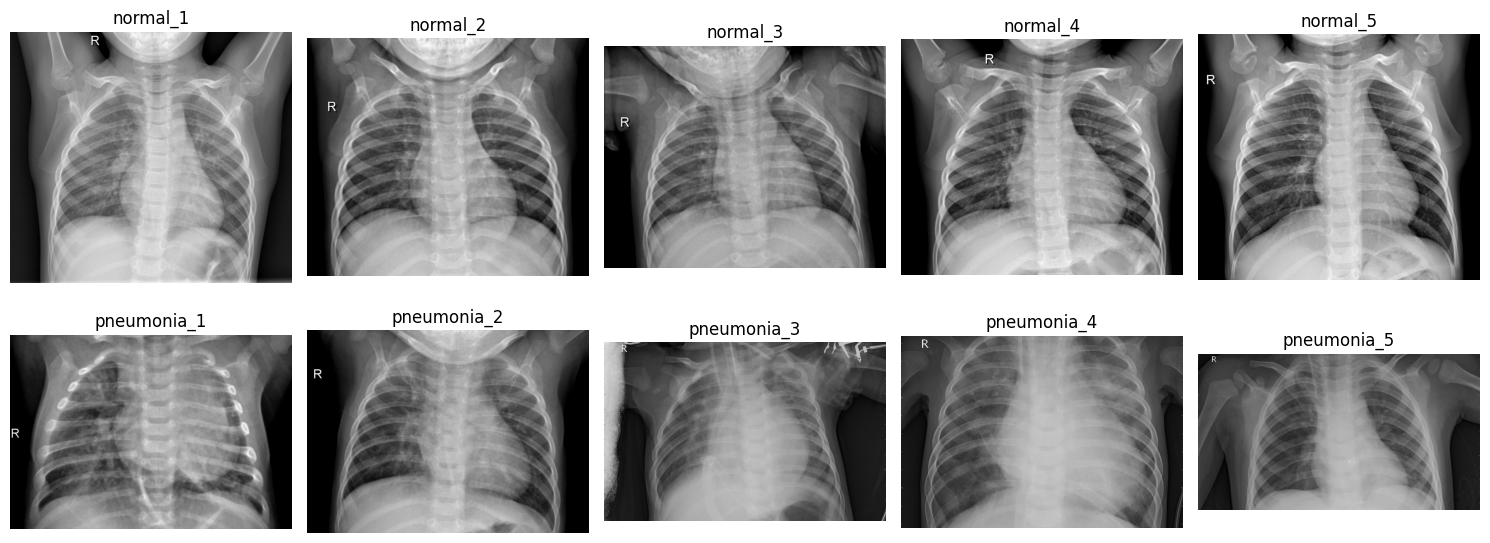

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/chest_xray_samples"
normal_dir = os.path.join(data_dir, "normal")
pneumonia_dir = os.path.join(data_dir, "pneumonia")

images = {}

normal_files = sorted([f for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))])[:5]
for i, f in enumerate(normal_files):
    name = f"normal_{i+1}"
    images[name] = {"path": os.path.join(normal_dir, f), "image": Image.open(os.path.join(normal_dir, f)).convert("RGB"), "condition": "normal"}

pneumonia_files = sorted([f for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))])[:5]
for i, f in enumerate(pneumonia_files):
    name = f"pneumonia_{i+1}"
    images[name] = {"path": os.path.join(pneumonia_dir, f), "image": Image.open(os.path.join(pneumonia_dir, f)).convert("RGB"), "condition": "pneumonia"}

print(f"loaded {len(images)} images")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for name, data in images.items():
    row = 0 if "normal" in name else 1
    col = int(name.split("_")[1]) - 1
    axes[row, col].imshow(data["image"], cmap='gray')
    axes[row, col].set_title(name)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# **Prompts**

In [7]:
def get_prompts(condition):
    if condition == "normal":
        return [
            ("Is there pneumonia in this X-ray?", False, "affirmative"),
            ("Is there a pleural effusion in this X-ray?", False, "affirmative"),
            ("Is there no pneumonia in this X-ray?", True, "negated"),
            ("Is there no pleural effusion in this X-ray?", True, "negated"),
            # ("Is there right-sided pneumonia?", False, "left_right"),
            # ("Is there left-sided pneumonia?", False, "left_right"),
        ]
    else:
        return [
            ("Is there pneumonia in this X-ray?", True, "affirmative"),
            ("Is there consolidation in this X-ray?", True, "affirmative"),
            ("Is there no pneumonia in this X-ray?", False, "negated"),
            ("Is there no lung abnormality in this X-ray?", False, "negated"),
            # ("Is there right-sided pneumonia?", True, "left_right"),
            # ("Is there left-sided pneumonia?", True, "left_right"),
        ]

all_test_cases = []
for img_name, data in images.items():
    for prompt, expected, prompt_type in get_prompts(data["condition"]):
        all_test_cases.append({
            "image_name": img_name,
            "prompt": prompt,
            "ground_truth": expected,
            "prompt_type": prompt_type,
            "condition": data["condition"],
        })

print(f"total: {len(all_test_cases)} test cases")
print(f"affirmative: {sum(1 for x in all_test_cases if x['prompt_type'] == 'affirmative')}")
print(f"negated: {sum(1 for x in all_test_cases if x['prompt_type'] == 'negated')}")
print(f"left_right: {sum(1 for x in all_test_cases if x['prompt_type'] == 'left_right')}")

total: 40 test cases
affirmative: 20
negated: 20
left_right: 0


# **LLaVA-Med**

In [8]:
from transformers import AutoProcessor, AutoModelForVision2Seq, LlavaForConditionalGeneration
import torch
from tqdm import tqdm
import pandas as pd
from PIL import Image

# Load model and processor
processor = AutoProcessor.from_pretrained("chaoyinshe/llava-med-v1.5-mistral-7b-hf")
model = LlavaForConditionalGeneration.from_pretrained(
    "chaoyinshe/llava-med-v1.5-mistral-7b-hf",
    torch_dtype=torch.float16,
    device_map="auto"
)

processor_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [9]:
def build_llava_prompt(processor, question: str) -> str:
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": question},
            ],
        }
    ]
    return processor.apply_chat_template(conversation, add_generation_prompt=True)

In [ ]:
img = images["pneumonia_1"]["image"]
q = "Where is the pneumonia in this X-ray?"

out = vcd_generate_hf_llava(
    model=model,
    processor=processor,
    question=q,
    image=img,
    alpha=1.0,
    beta=0.01,
    noise_step=500,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    max_new_tokens=80
)

print(out)


In [ ]:
# baseline generate
text = build_llava_prompt(processor, q)
inputs = processor(images=img, text=text, return_tensors="pt").to(model.get_input_embeddings().weight.device)

baseline_ids = model.generate(
    **inputs,
    max_new_tokens=80,
    do_sample=True,
    temperature=0.7,
    top_p=0.9
)

baseline = processor.tokenizer.decode(baseline_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)

# VCD generate
vcd = vcd_generate_hf_llava(
    model=model,
    processor=processor,
    question=q,
    image=img,
    max_new_tokens=80,
    alpha=1.0,
    beta=0.1,
    noise_step=500,
    do_sample=True,
    temperature=0.7,
    top_p=0.9
)

print("BASELINE:", baseline)
print("VCD     :", vcd)

BASELINE: The pneumonia is located in the right lower lung zone, as indicated by the arrow in the chest X-ray. 
VCD     : In this chest X-ray, the pneumonia is located in the right upper lobe of the lung. 


In [25]:
def parse_model_response(response, prompt):
    """
    Determine if model affirmed the finding.
    Returns: (model_said_yes: bool, extracted_answer: str)
    """
    response_lower = response.lower()

    # Check for explicit negations first
    negations = ["no", "not visible", "not present", "absent", "cannot see",
                 "no evidence", "negative", "no sign"]
    if any(neg in response_lower for neg in negations):
        return False, response

    # Check for affirmations
    affirmations = ["yes", "present", "visible", "detected", "observed",
                    "shows", "demonstrates", "there is"]
    if any(aff in response_lower for aff in affirmations):
        return True, response

    # Default to uncertain
    return None, response

def run_generation(method, model, processor, prompt, image, vcd_kwargs=None):
    """
    Returns: outputs object with .sequences and .scores
    """
    if method == "baseline":
        inputs = processor(
            text=prompt,
            images=image,
            return_tensors="pt",
            padding=True
        ).to(model.device)

        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            return_dict_in_generate=True,
            output_scores=True
        )
        return outputs

    elif method == "vcd":
        # IMPORTANT: your vcd function expects the QUESTION (not "USER: <image> ...")
        # We'll pass the raw question separately (see loop below).
        # Here we just return what vcd_generate_hf_llava returns.
        return vcd_generate_hf_llava(
            model=model,
            processor=processor,
            question=vcd_kwargs["question"],
            image=image,
            max_new_tokens=200,
            alpha=vcd_kwargs.get("alpha", 1.0),
            beta=vcd_kwargs.get("beta", 0.01),
            do_sample=vcd_kwargs.get("do_sample", True),
            temperature=vcd_kwargs.get("temperature", 0.7),
            top_p=vcd_kwargs.get("top_p", 0.9),
            return_dict_in_generate=True,
            output_scores=True,
        )
    else:
        raise ValueError(f"Unknown method: {method}")


results = []
methods = ["baseline", "vcd"]

for test_case in tqdm(all_test_cases, desc="Running LLaVA-Med inference (baseline + VCD)"):
    image_path = images[test_case["image_name"]]["path"]
    image = Image.open(image_path)

    baseline_prompt = build_llava_prompt(processor, test_case["prompt"])

    for method in methods:
        # --- generate ---
        if method == "baseline":
            outputs = run_generation(
                method="baseline",
                model=model,
                processor=processor,
                prompt=baseline_prompt,
                image=image
            )
        else:
            outputs = run_generation(
                method="vcd",
                model=model,
                processor=processor,
                prompt=None,         # not used for vcd
                image=image,
                vcd_kwargs={
                    "question": test_case["prompt"],  # raw question for VCD builder
                    "alpha": 1.0,
                    "beta": 0.01,
                    "do_sample": True,
                    "temperature": 0.7,
                    "top_p": 0.9,
                }
            )

        # --- confidence (same logic as baseline) ---
        transition_scores = model.compute_transition_scores(
            outputs.sequences,
            outputs.scores,
            normalize_logits=True
        )
        mean_confidence = transition_scores.mean().item()

        # --- decode ---
        response = processor.decode(outputs.sequences[0], skip_special_tokens=True)

        # --- parse response ---
        model_said_yes, extracted = parse_model_response(response, test_case["prompt"])

        # --- correctness ---
        is_correct = (model_said_yes == test_case["ground_truth"]) if model_said_yes is not None else False

        # --- store ---
        results.append({
            **test_case,
            "method": method,
            "response": response,
            "extracted_answer": extracted,
            "confidence": mean_confidence,
            "model_said_yes": model_said_yes,
            "is_correct": is_correct,
            "is_false_positive": (bool(model_said_yes) and not test_case["ground_truth"]),
        })

        torch.cuda.empty_cache()


df_all = pd.DataFrame(results)
df_all.to_csv("llava_med_results_baseline_and_vcd.csv", index=False)

print("\n" + "="*60)
print("LLaVA-Med Results Summary (Baseline vs VCD)")
print("="*60)

for method in df_all["method"].unique():
    df_m = df_all[df_all["method"] == method]

    print(f"\n--- {method.upper()} ---")
    print(f"Overall accuracy: {df_m['is_correct'].mean():.2%}")

    false_premises = df_m[df_m["ground_truth"] == False]
    print("False Premise Performance:")
    print(f"  Total false premises: {len(false_premises)}")
    print(f"  Model said 'Yes' (false positives): {false_premises['model_said_yes'].sum()}")
    print(f"  False positive rate: {false_premises['model_said_yes'].mean():.2%}")

    print("Confidence Scores (Mean Log-Probability):")
    print(f"  True cases: {df_m[df_m['ground_truth']==True]['confidence'].mean():.3f}")
    print(f"  False premises: {df_m[df_m['ground_truth']==False]['confidence'].mean():.3f}")

    print("Performance by Prompt Type:")
    for ptype in df_m["prompt_type"].unique():
        subset = df_m[df_m["prompt_type"] == ptype]
        print(f"  {ptype}: {subset['is_correct'].mean():.2%} accuracy")

print("\n" + "="*60)

print("\nFirst 5 test cases (baseline):")
print(df_all[df_all["method"] == "baseline"][['image_name','prompt','ground_truth','model_said_yes','confidence','is_correct']].head())

print("\nFirst 5 test cases (vcd):")
print(df_all[df_all["method"] == "vcd"][['image_name','prompt','ground_truth','model_said_yes','confidence','is_correct']].head())

Running LLaVA-Med inference (baseline + VCD): 100%|██████████| 40/40 [18:35<00:00, 27.89s/it]


LLaVA-Med Results Summary (Baseline vs VCD)

--- BASELINE ---
Overall accuracy: 50.00%
False Premise Performance:
  Total false premises: 20
  Model said 'Yes' (false positives): 0
  False positive rate: 0.00%
Confidence Scores (Mean Log-Probability):
  True cases: -0.229
  False premises: -0.220
Performance by Prompt Type:
  affirmative: 50.00% accuracy
  negated: 50.00% accuracy

--- VCD ---
Overall accuracy: 52.50%
False Premise Performance:
  Total false premises: 20
  Model said 'Yes' (false positives): 1
  False positive rate: 5.00%
Confidence Scores (Mean Log-Probability):
  True cases: -0.287
  False premises: -0.281
Performance by Prompt Type:
  affirmative: 55.00% accuracy
  negated: 50.00% accuracy


First 5 test cases (baseline):
  image_name                                       prompt  ground_truth  \
0   normal_1            Is there pneumonia in this X-ray?         False   
2   normal_1   Is there a pleural effusion in this X-ray?         False   
4   normal_1         I

In [26]:
import numpy as np
import pandas as pd

df_all = pd.DataFrame(results)  # results contains BOTH baseline + vcd rows

# Rename for clarity
df_all = df_all.rename(columns={'confidence': 'confidence_logprob'})

# Add probability column (convert from log-probability)
df_all['confidence_prob'] = np.exp(df_all['confidence_logprob'])

# Reorder columns to put them side by side
cols = df_all.columns.tolist()
confidence_idx = cols.index('confidence_logprob')
cols.insert(confidence_idx + 1, cols.pop(cols.index('confidence_prob')))
df_all = df_all[cols]

df_all.to_csv("llava_med_results_baseline_and_vcd.csv", index=False)

print("\nConfidence columns (sample):")
print(df_all[['method','prompt','confidence_logprob','confidence_prob','model_said_yes']].head())



Confidence columns (sample):
     method                                      prompt  confidence_logprob  \
0  baseline           Is there pneumonia in this X-ray?           -0.282583   
1       vcd           Is there pneumonia in this X-ray?           -0.324219   
2  baseline  Is there a pleural effusion in this X-ray?           -0.152530   
3       vcd  Is there a pleural effusion in this X-ray?           -0.245239   
4  baseline        Is there no pneumonia in this X-ray?           -0.219594   

   confidence_prob  model_said_yes  
0         0.753834           False  
1         0.723092           False  
2         0.858534           False  
3         0.782517            True  
4         0.802845           False  



AGGREGATED CONFIDENCE SCORES (Baseline vs VCD)

--- BASELINE ---
Mean Log-Probability (aggregated over all response tokens):
  True cases:  -0.2292
  False premises: -0.2200
  Difference: -0.0092
Mean Probability (converted):
  True cases:  0.7955
  False premises: 0.8033
Sample sizes: true n=20, false n=20

--- VCD ---
Mean Log-Probability (aggregated over all response tokens):
  True cases:  -0.2874
  False premises: -0.2812
  Difference: -0.0062
Mean Probability (converted):
  True cases:  0.7529
  False premises: 0.7601
Sample sizes: true n=20, false n=20


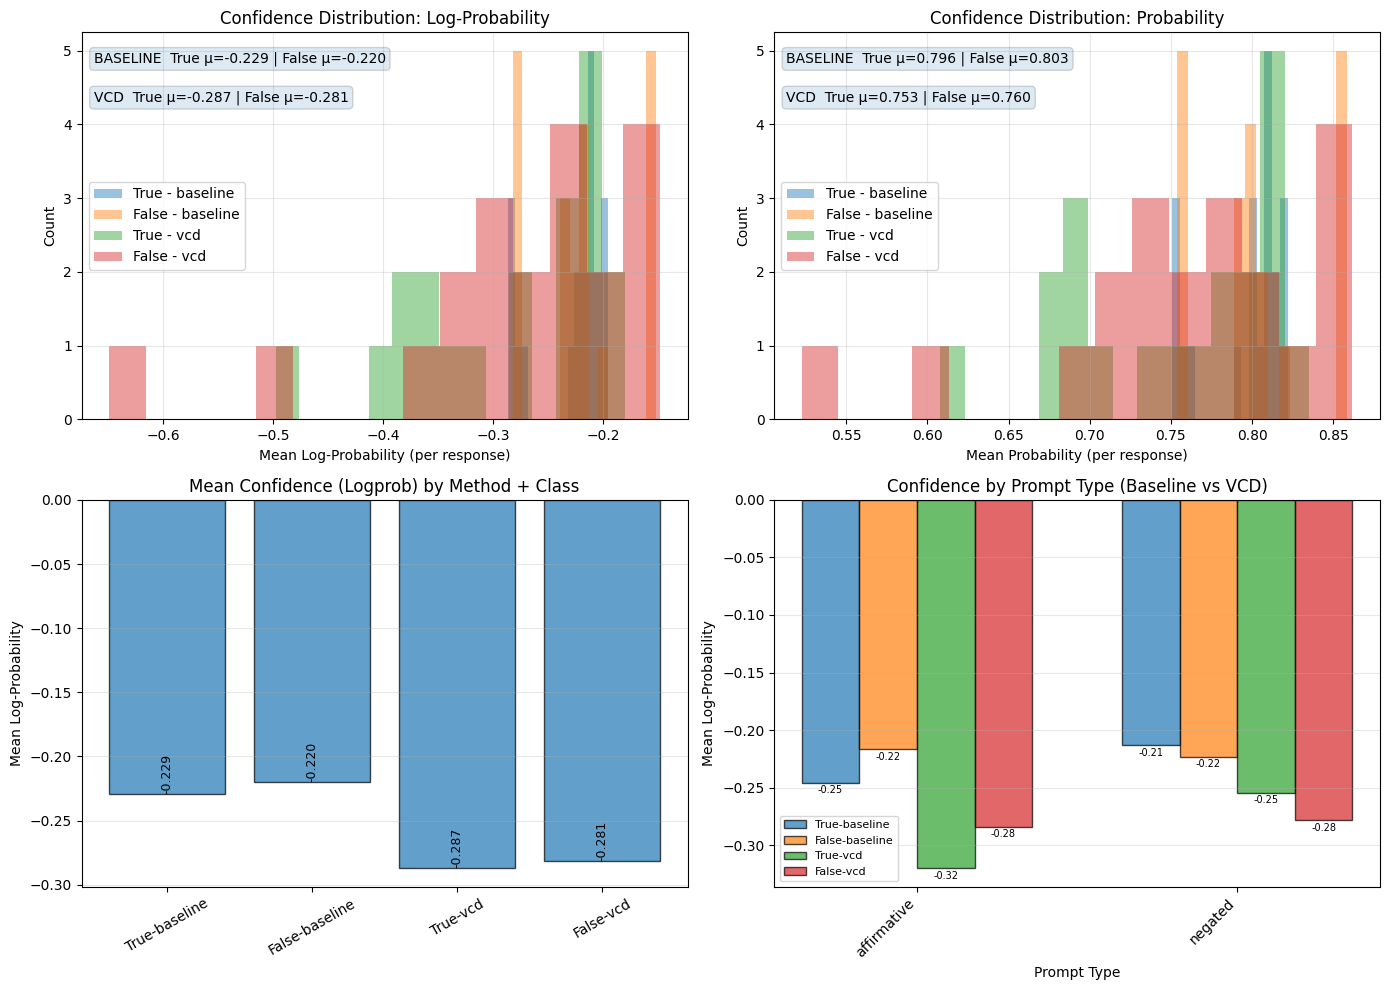


✓ Figure saved as 'llava_med_confidence_analysis_baseline_vs_vcd.png'


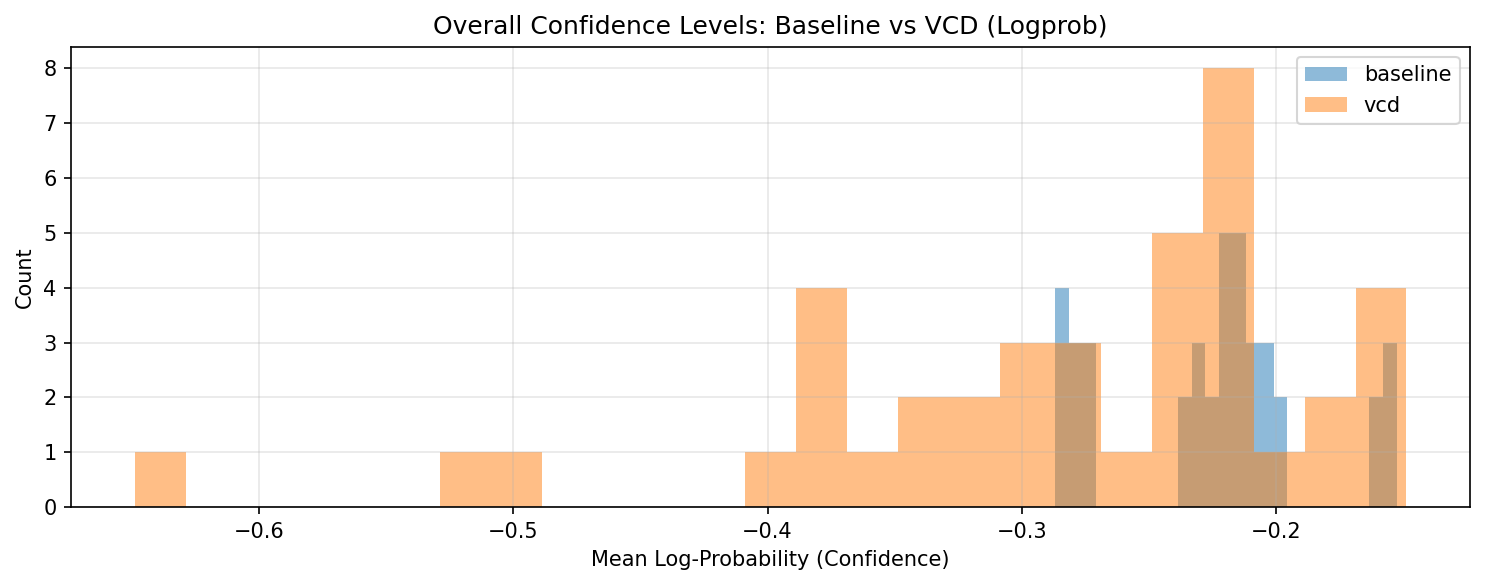

✓ Figure saved as 'llava_med_overall_confidence_levels_baseline_vs_vcd.png'


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# df_all must already exist and contain:
#   - method: "baseline" / "vcd"
#   - ground_truth: True/False
#   - confidence_logprob
#   - confidence_prob
#   - prompt_type

print("\n" + "="*60)
print("AGGREGATED CONFIDENCE SCORES (Baseline vs VCD)")
print("="*60)

methods = ["baseline", "vcd"]
methods = [m for m in methods if m in df_all["method"].unique()]  # keep only those present

for method in methods:
    df_m = df_all[df_all["method"] == method]
    true_cases = df_m[df_m["ground_truth"] == True]
    false_premises = df_m[df_m["ground_truth"] == False]

    print(f"\n--- {method.upper()} ---")
    print("Mean Log-Probability (aggregated over all response tokens):")
    print(f"  True cases:  {true_cases['confidence_logprob'].mean():.4f}")
    print(f"  False premises: {false_premises['confidence_logprob'].mean():.4f}")
    print(f"  Difference: {true_cases['confidence_logprob'].mean() - false_premises['confidence_logprob'].mean():.4f}")

    print("Mean Probability (converted):")
    print(f"  True cases:  {true_cases['confidence_prob'].mean():.4f}")
    print(f"  False premises: {false_premises['confidence_prob'].mean():.4f}")

    print(f"Sample sizes: true n={len(true_cases)}, false n={len(false_premises)}")


# =========================
# Plots
# =========================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Log-prob distribution, overlay baseline vs vcd (true + false)
ax1 = axes[0, 0]
for method in methods:
    df_m = df_all[df_all["method"] == method]
    ax1.hist(df_m[df_m["ground_truth"] == True]["confidence_logprob"], bins=15, alpha=0.45, label=f"True - {method}")
    ax1.hist(df_m[df_m["ground_truth"] == False]["confidence_logprob"], bins=15, alpha=0.45, label=f"False - {method}")
ax1.set_xlabel("Mean Log-Probability (per response)")
ax1.set_ylabel("Count")
ax1.set_title("Confidence Distribution: Log-Probability")
ax1.legend()
ax1.grid(alpha=0.3)

# Write means on ax1
for i, method in enumerate(methods):
    df_m = df_all[df_all["method"] == method]
    mu_true = df_m[df_m["ground_truth"] == True]["confidence_logprob"].mean()
    mu_false = df_m[df_m["ground_truth"] == False]["confidence_logprob"].mean()
    ax1.text(
        0.02, 0.95 - i*0.1,
        f"{method.upper()}  True μ={mu_true:.3f} | False μ={mu_false:.3f}",
        transform=ax1.transAxes,
        fontsize=10,
        va="top",
        bbox=dict(boxstyle="round", alpha=0.15)
    )

# 2) Probability distribution, overlay baseline vs vcd (true + false)
ax2 = axes[0, 1]
for method in methods:
    df_m = df_all[df_all["method"] == method]
    ax2.hist(df_m[df_m["ground_truth"] == True]["confidence_prob"], bins=15, alpha=0.45, label=f"True - {method}")
    ax2.hist(df_m[df_m["ground_truth"] == False]["confidence_prob"], bins=15, alpha=0.45, label=f"False - {method}")
ax2.set_xlabel("Mean Probability (per response)")
ax2.set_ylabel("Count")
ax2.set_title("Confidence Distribution: Probability")
ax2.legend()
ax2.grid(alpha=0.3)

# Write means on ax2
for i, method in enumerate(methods):
    df_m = df_all[df_all["method"] == method]
    mu_true = df_m[df_m["ground_truth"] == True]["confidence_prob"].mean()
    mu_false = df_m[df_m["ground_truth"] == False]["confidence_prob"].mean()
    ax2.text(
        0.02, 0.95 - i*0.1,
        f"{method.upper()}  True μ={mu_true:.3f} | False μ={mu_false:.3f}",
        transform=ax2.transAxes,
        fontsize=10,
        va="top",
        bbox=dict(boxstyle="round", alpha=0.15)
    )

# 3) Bar chart: mean confidence per method + class (true/false) [LOGPROB]
ax3 = axes[1, 0]
labels = []
vals = []
for method in methods:
    df_m = df_all[df_all["method"] == method]
    vals.append(df_m[df_m["ground_truth"] == True]["confidence_logprob"].mean())
    labels.append(f"True-{method}")
    vals.append(df_m[df_m["ground_truth"] == False]["confidence_logprob"].mean())
    labels.append(f"False-{method}")

bars = ax3.bar(labels, vals, alpha=0.7, edgecolor="black")
ax3.set_ylabel("Mean Log-Probability")
ax3.set_title("Mean Confidence (Logprob) by Method + Class")
ax3.grid(axis="y", alpha=0.3)
ax3.tick_params(axis="x", rotation=30)

# Label bars with values
for bar in bars:
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=90
    )

# 4) By prompt type: baseline vs vcd for true/false (logprob)
ax4 = axes[1, 1]
prompt_types = sorted(df_all["prompt_type"].unique())
x = np.arange(len(prompt_types))
width = 0.18

for j, method in enumerate(methods):
    df_m = df_all[df_all["method"] == method]
    true_by_type = [
        df_m[(df_m["prompt_type"] == pt) & (df_m["ground_truth"] == True)]["confidence_logprob"].mean()
        for pt in prompt_types
    ]
    false_by_type = [
        df_m[(df_m["prompt_type"] == pt) & (df_m["ground_truth"] == False)]["confidence_logprob"].mean()
        for pt in prompt_types
    ]
    ax4.bar(x + (j*2 - 1)*width, true_by_type, width, alpha=0.7, edgecolor="black", label=f"True-{method}")
    ax4.bar(x + (j*2)*width, false_by_type, width, alpha=0.7, edgecolor="black", label=f"False-{method}")

ax4.set_xlabel("Prompt Type")
ax4.set_ylabel("Mean Log-Probability")
ax4.set_title("Confidence by Prompt Type (Baseline vs VCD)")
ax4.set_xticks(x + width/2)
ax4.set_xticklabels(prompt_types, rotation=45, ha="right")
ax4.legend(fontsize=8)
ax4.grid(axis="y", alpha=0.3)

# Add compact bar labels (may be crowded if many prompt types)
for container in ax4.containers:
    ax4.bar_label(container, fmt="%.2f", fontsize=7, padding=2)

plt.tight_layout()
plt.savefig("llava_med_confidence_analysis_baseline_vs_vcd.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✓ Figure saved as 'llava_med_confidence_analysis_baseline_vs_vcd.png'")


# =========================
# EXTRA: Confidence-level plot (baseline vs vcd, regardless of ground_truth)
# =========================

plt.figure(figsize=(10, 4), dpi=150)
for method in methods:
    subset = df_all[df_all["method"] == method]
    plt.hist(subset["confidence_logprob"], bins=25, alpha=0.5, label=method)

plt.xlabel("Mean Log-Probability (Confidence)")
plt.ylabel("Count")
plt.title("Overall Confidence Levels: Baseline vs VCD (Logprob)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("llava_med_overall_confidence_levels_baseline_vs_vcd.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Figure saved as 'llava_med_overall_confidence_levels_baseline_vs_vcd.png'")